Evolução de um Pacote de Onda Plana
----------------------------------------

O procedimento aqui consiste na evolução temporal de um pacote de onda ao longo de um percurso.

A evolução temporal é realizada utilizando diferentes métodos numéricos e o objetivo é compará-los em relação à precisão e performance.

# Pacote de Onda

O Pacote de onda utilizado é mostrado na equação à seguir:

$$
\Psi(x,t) = \frac{1}{ \sqrt[4]{ 2 \pi {\sigma_x}^2 }} \exp \left( i k_0 x - \frac{{\left( x - x_0 \right)}^2}{4 {\left(\sigma_x \right)}^2} \right)
$$

Sua energia é a de uma onda plana:

$$
E_0 = \frac{\hbar^2 k_0^2}{2 m} \rightarrow k_0 = \sqrt{\frac{2m E_0}{\hbar^2}}
$$

São utilizadas as seguintes bibliotecas e configurações

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# matplotlib defaults setup
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "computer modern sans serif"

import numpy as np
from scipy.integrate import simps
import scipy.constants as cte
from scipy.sparse import diags

Os parâmetros utilizados por todos os métodos são configurados à seguir.

In [2]:
# grandezas de interesse em unidades atomicas
au_l = cte.value('atomic unit of length')
au_t = cte.value('atomic unit of time')
au_e = cte.value('atomic unit of energy')

# outras relacoes de interesse
ev = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev = au_e / ev

# unidades do problema
E_0 = 150.0 # eV
L = 60.0 # angstron
sigma_x = 1.0 # angstron
x_0 = -20.0 # angstron
dt = dt_0 = 1e-15 # s

# unidades atomicas
E_0_au = E_0 / au2ev
L_au = L / au2ang
sigma_x_au = sigma_x / au2ang
x_0_au = x_0 / au2ang
dt_au = dt / au_t
k_0_au = np.sqrt(2 * E_0_au)

Na figura à seguir é mostrada a onda em sua posição inicial e final. É esperado que 

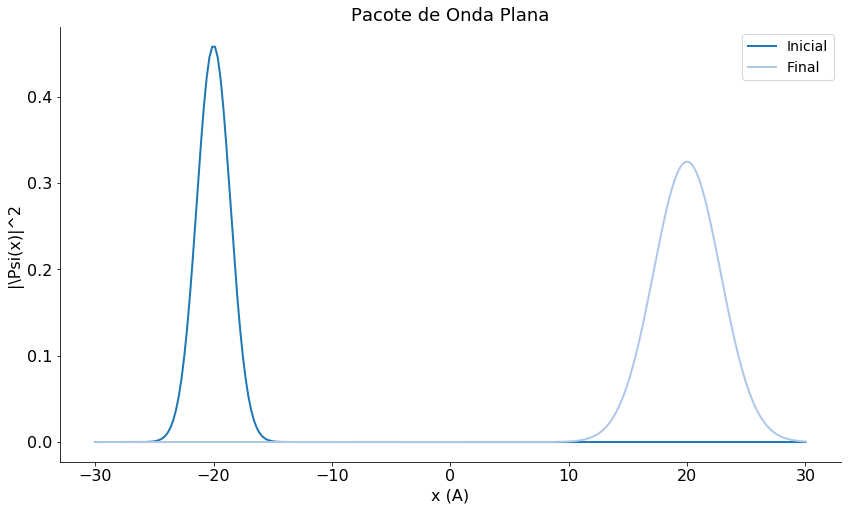

In [13]:
# malha espacial
x_au = np.linspace(-L_au/2, L_au/2, 256)

# pacote de onda
PN = 1/(2*np.pi*sigma_x_au**2)**(1/4)
PNf = 1/(2*np.pi*4*sigma_x_au**2)**(1/4)
psi = PN*np.exp(1j*k_0_au*x_au-(x_au-x_0_au)**2/(4*sigma_x_au**2))
psif = PNf*np.exp(1j*k_0_au*x_au-(x_au+x_0_au)**2/(4*4*sigma_x_au**2))

ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.title("Pacote de Onda Plana", fontsize=18)
plt.xlabel("x (A)", fontsize=16)
plt.ylabel("|\Psi(x)|^2", fontsize=16)

line, = plt.plot(x_au * au2ang, np.abs(psi), lw=2.0, color=(31/255, 119/255, 180/255), label='Inicial')
plt.legend(handles=[line], loc=1)

line2, = plt.plot(x_au * au2ang, np.abs(psif), lw=2.0, color=(174/255, 199/255, 232/255), label='Final')
plt.legend(handles=[line2], loc=2)

plt.legend()
plt.show()

In [3]:
# salva os valores onde o algoritmo converge
par_convergentes = []

# divisor esperto (?)
de = lambda x: 2 if int((x/(10**(int(np.log10(x))-1)))%2) == 0 else 5

for N in [2**n for n in range(8,12)]:
    dt = dt_0
    
    # malha espacial
    x_au = np.linspace(-L_au/2, L_au/2, N)
    dx_au = x_au[1] - x_au[0]
    # diferencas finitas
    alpha = 1j / (2 * dx_au ** 2)
    beta = - 1j / (dx_au ** 2)
    diagonal_1 = [beta] * N
    diagonal_2 = [alpha] * (N - 1)
    diagonais = [diagonal_1, diagonal_2, diagonal_2]
    M = diags(diagonais, [0, -1, 1]).toarray()
    
    while True:
        #dt /= 10
        dt /= de(dt)
        dt_au = dt / au_t
        
        
        # pacote de onda
        PN = 1/(2*np.pi*sigma_x_au**2)**(1/4)
        psi = PN*np.exp(1j*k_0_au*x_au-(x_au-x_0_au)**2/(4*sigma_x_au**2))
        A0 = (simps(np.conjugate(psi)*psi,x_au)).real
        x_f_au = x_0_au 
        
        funcionou = True
        contador = 0
        norma = 100
        
        while x_f_au < -x_0_au:
            try:
                k1 = M.dot(psi)
                k2 = M.dot(psi + dt_au * k1 / 2)
                k3 = M.dot(psi + dt_au * k2 / 2)
                k4 = M.dot(psi + dt_au * k3)
                psi += dt_au * (k1 + 2 * k2 + 2 * k3 + k4) / 6
                
                contador += 1
                if contador % 10 == 0:
                    A = (simps(np.conjugate(psi)*psi,x_au)).real
                    norma = 100 * A / A0
                    if np.abs(norma - 100) > 5:
                        funcionou = False
                        break
                    x_f_au = xm = (simps(np.conjugate(psi)* x_au * psi,x_au)).real / A
            except:
                funcionou = False
                break
                
        parametros = (N, dt, norma, contador)
        if funcionou:
            par_convergentes.append(parametros)
            break
        try:
            print("Estouro de norma: N = {}, dt={:.2e} s, norma = {:.2f}, contador = {}".format(*parametros))
        except:
            print("Grande estouro de norma: N = {}, dt={:.2e} s, contador = {}".format(N, dt, contador))
#                 xm2 = (simps(np.conjugate(psi)* x_au**2 * psi,x_au)).real / A
#                 sigma = np.sqrt(np.abs(xm2 - xm**2))
#                 print("A = {:.5f} %, <x> = {:.5f} A, sigma = {:.5f}".format(norma, xm, sigma))
#             if st % 10 == 0 or st == Ns-1:
#                 plt.plot(x_au, np.abs(psi))
#                 plt.show()
print(par_convergentes)

Estouro de norma: N = 256, dt=5.00e-16 s, norma = 832847568522783709322823557250886242888664727369208005168575733506744918062878437353741718113286250832312471611053779995022509707971203795255296.00, contador = 10
Estouro de norma: N = 256, dt=1.00e-16 s, norma = 9312993282851284504688969007866838387979645344278093976788812979348842008944755741818880.00, contador = 10
Estouro de norma: N = 256, dt=5.00e-17 s, norma = 6015442666855499617990281442811504461889429827275361890917679104.00, contador = 10
Estouro de norma: N = 256, dt=1.00e-17 s, norma = 533.01, contador = 10
Estouro de norma: N = 256, dt=5.00e-18 s, norma = 89.83, contador = 10
Estouro de norma: N = 512, dt=5.00e-16 s, norma = 12641680852954580341351681869891295474175056788944785737743831747063194737983345120343715619075358670477150001518996723135097061790632544009480717572557625251133027041848220750708736.00, contador = 10
Estouro de norma: N = 512, dt=1.00e-16 s, norma = 15239493132587178924615008769680278739207406899702568

In [4]:
np.ones(2)+7

array([ 8.,  8.])

In [8]:
100-99.999808744336349

0.00019125566365119084